In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2025-01-24 09:27:37.344520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 09:27:37.344582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 09:27:37.344624: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 09:27:37.353691: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [3]:
train_df = pd.read_csv('../newKDDTrain+.txt', header=None)

columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
train_df.columns = columns

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
test_df = pd.read_csv('../newKDDTest+.txt', header=None)

test_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
test_df.columns = columns

test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


In [5]:
kdd_df = pd.concat([train_df, test_df])

In [6]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [7]:
train_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_training-set.csv")

In [8]:
test_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_testing-set.csv")

In [9]:
unsw_df=pd.concat([train_df, test_df], axis=0)

In [10]:
kdd_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [11]:
unsw_df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [12]:
kdd_df['service'].value_counts()

http         48191
private      26627
domain_u      9937
smtp          8247
ftp_data      7711
             ...  
tftp_u           4
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

In [13]:
# 각 데이터셋의 컬럼 분포(값의 범위) 확인

def dataset_column_distribution(df, dataset_name):
    print(f"\n{dataset_name} Dataset Column Distributions:\n")
    for column in df.columns:
        col_data = df[column]
        if col_data.dtype in ['int64', 'float64']:
            print(f"{column}: Min={col_data.min()}, Max={col_data.max()}, Mean={col_data.mean():.2f}, Std={col_data.std():.2f}")
        else:
            print(f"{column}: Non-numeric column, Unique Values={col_data.nunique()}")

# KDD 데이터셋 컬럼 분포 확인
dataset_column_distribution(kdd_df, "KDD")

# CIC-IDS 데이터셋 컬럼 분포 확인
dataset_column_distribution(unsw_df, "UNSW-NB15")


KDD Dataset Column Distributions:

duration: Min=0, Max=57715, Mean=276.78, Std=2460.68
protocol_type: Non-numeric column, Unique Values=3
service: Non-numeric column, Unique Values=70
flag: Non-numeric column, Unique Values=11
src_bytes: Min=0, Max=1379963888, Mean=40227.95, Std=5409611.60
dst_bytes: Min=0, Max=1309937401, Mean=17088.85, Std=3703524.78
land: Min=0, Max=1, Mean=0.00, Std=0.01
wrong_fragment: Min=0, Max=3, Mean=0.02, Std=0.24
urgent: Min=0, Max=3, Mean=0.00, Std=0.02
hot: Min=0, Max=101, Mean=0.19, Std=2.01
num_failed_logins: Min=0, Max=5, Mean=0.00, Std=0.07
logged_in: Min=0, Max=1, Mean=0.40, Std=0.49
num_compromised: Min=0, Max=7479, Mean=0.26, Std=22.23
root_shell: Min=0, Max=1, Mean=0.00, Std=0.04
su_attempted: Min=0, Max=2, Mean=0.00, Std=0.04
num_root: Min=0, Max=7468, Mean=0.27, Std=22.69
num_file_creations: Min=0, Max=100, Mean=0.01, Std=0.52
num_shells: Min=0, Max=5, Mean=0.00, Std=0.03
num_access_files: Min=0, Max=9, Mean=0.00, Std=0.10
num_outbound_cmds: Mi

In [14]:
kdd_df['protocol_type'].value_counts()

tcp     121569
udp      17614
icmp      9334
Name: protocol_type, dtype: int64

In [15]:
# 매핑된 피처 중 분포가 너무 다르거나 의미가 불명확한 피처 제외
kdd_to_unsw_mapping = {
    "duration": "dur",
    "protocol_type": "proto",
    "service": "service",
    "src_bytes": "sbytes",
    "dst_bytes": "dbytes",
    "wrong_fragment": "sloss",  # 패킷 손실과 유사
    "urgent": "dloss",          # 수신 손실과 매핑
    "count": "spkts",           # 송신 패킷 수
    "srv_count": "dpkts",       # 수신 패킷 수
    "serror_rate": "smean",     # 송신 평균과 유사
    "srv_serror_rate": "dmean", # 수신 평균과 유사
    "same_srv_rate": "ct_srv_src", # 동일 서비스 소스 수
    "diff_srv_rate": "ct_dst_ltm", # 다른 서비스 목적지 수
    "is_guest_login": "is_ftp_login", # 비인가 로그인 여부
    "class": "label",           # 클래스 (공격 여부)
}

# 공통 컬럼 추출 및 이름 변경
def process_datasets(kdd_df, unsw_df, mapping):
    # KDD 데이터셋
    kdd_filtered = kdd_df[list(mapping.keys())].copy()
    kdd_filtered.rename(columns=mapping, inplace=True)

    # UNSW-NB15 데이터셋
    unsw_filtered = unsw_df[list(mapping.values())].copy()

    return kdd_filtered, unsw_filtered



# 데이터셋 처리 및 매핑 적용
new_kdd_df, new_unsw_df = process_datasets(kdd_df, unsw_df, kdd_to_unsw_mapping)


In [16]:
new_kdd_df

,dur,proto,service,sbytes,dbytes,sloss,dloss,spkts,dpkts,smean,dmean,ct_srv_src,ct_dst_ltm,is_ftp_login,label
0,0,tcp,ftp_data,491,0,0,0,2,2,0.0,0.0,1.00,0.00,0,normal
1,0,udp,other,146,0,0,0,13,1,0.0,0.0,0.08,0.15,0,normal
2,0,tcp,private,0,0,0,0,123,6,1.0,1.0,0.05,0.07,0,anomaly
3,0,tcp,http,232,8153,0,0,5,5,0.2,0.2,1.00,0.00,0,normal
4,0,tcp,http,199,420,0,0,30,32,0.0,0.0,1.00,0.00,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,794,333,0,0,1,1,0.0,0.0,1.00,0.00,0,normal
22540,0,tcp,http,317,938,0,0,2,11,0.0,0.0,1.00,0.00,0,normal
22541,0,tcp,http,54540,8314,0,0,5,10,0.0,0.0,1.00,0.00,0,anomaly
22542,0,udp,domain_u,42,42,0,0,4,6,0.0,0.0,1.00,0.00,0,normal


In [17]:
new_unsw_df

,dur,proto,service,sbytes,dbytes,sloss,dloss,spkts,dpkts,smean,dmean,ct_srv_src,ct_dst_ltm,is_ftp_login,label
0,0.121478,tcp,-,258,172,0,0,6,4,43,43,1,1,0,0
1,0.649902,tcp,-,734,42014,2,17,14,38,52,1106,43,1,0,0
2,1.623129,tcp,-,364,13186,1,6,8,16,46,824,7,2,0,0
3,1.681642,tcp,ftp,628,770,1,3,12,12,52,64,1,2,1,0
4,0.449454,tcp,-,534,268,2,1,10,6,53,45,43,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,104,0,0,0,2,0,52,0,1,2,0,0
82328,1.106101,tcp,-,18062,354,7,1,20,8,903,44,1,2,0,0
82329,0.000000,arp,-,46,0,0,0,1,0,46,0,1,1,0,0
82330,0.000000,arp,-,46,0,0,0,1,0,46,0,1,1,0,0


In [18]:
new_kdd_df['label'] = new_kdd_df['label'].apply(lambda x: 0 if x == 'normal' else 1)


In [19]:
new_kdd_df['label'].value_counts()

0    77054
1    71463
Name: label, dtype: int64

In [20]:
new_kdd_df.columns==new_unsw_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [21]:
print("cicids shape : ",new_unsw_df.shape)
print("kdd shape : ",new_kdd_df.shape)


cicids shape :  (257673, 15)
kdd shape :  (148517, 15)


In [22]:
new_kdd_df

,dur,proto,service,sbytes,dbytes,sloss,dloss,spkts,dpkts,smean,dmean,ct_srv_src,ct_dst_ltm,is_ftp_login,label
0,0,tcp,ftp_data,491,0,0,0,2,2,0.0,0.0,1.00,0.00,0,0
1,0,udp,other,146,0,0,0,13,1,0.0,0.0,0.08,0.15,0,0
2,0,tcp,private,0,0,0,0,123,6,1.0,1.0,0.05,0.07,0,1
3,0,tcp,http,232,8153,0,0,5,5,0.2,0.2,1.00,0.00,0,0
4,0,tcp,http,199,420,0,0,30,32,0.0,0.0,1.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,794,333,0,0,1,1,0.0,0.0,1.00,0.00,0,0
22540,0,tcp,http,317,938,0,0,2,11,0.0,0.0,1.00,0.00,0,0
22541,0,tcp,http,54540,8314,0,0,5,10,0.0,0.0,1.00,0.00,0,1
22542,0,udp,domain_u,42,42,0,0,4,6,0.0,0.0,1.00,0.00,0,0


In [23]:
# 프로토콜 매핑 사전
protocol_map = {
    'tcp': 6,    # TCP
    'udp': 17,   # UDP
    'icmp': 1    # ICMP
}

# 나머지 값은 0으로 처리
new_kdd_df['Protocol_Mapped'] = new_kdd_df['proto'].str.lower().map(protocol_map).fillna(0).astype(int)

new_kdd_df['proto'] = new_kdd_df['Protocol_Mapped']
new_kdd_df = new_kdd_df.drop(labels='Protocol_Mapped', axis=1)

In [24]:
# 프로토콜 매핑 사전
protocol_map = {
    'tcp': 6,    # TCP
    'udp': 17,   # UDP
    'icmp': 1    # ICMP
}

# 나머지 값은 0으로 처리
new_unsw_df['Protocol_Mapped'] = new_unsw_df['proto'].str.lower().map(protocol_map).fillna(0).astype(int)

new_unsw_df['proto'] = new_unsw_df['Protocol_Mapped']
new_unsw_df = new_unsw_df.drop(labels='Protocol_Mapped', axis=1)

In [25]:
new_kdd_df['proto'].value_counts()

6     121569
17     17614
1       9334
Name: proto, dtype: int64

In [26]:
new_kdd_df['service'].value_counts()

http         48191
private      26627
domain_u      9937
smtp          8247
ftp_data      7711
             ...  
tftp_u           4
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

In [27]:
new_unsw_df['service'].value_counts()

-           141321
dns          68661
http         27011
smtp          6909
ftp-data      5391
ftp           4980
pop3          1528
ssh           1506
dhcp           120
snmp           109
ssl             86
irc             30
radius          21
Name: service, dtype: int64

In [28]:
new_kdd_df.shape

(148517, 15)

In [29]:
new_unsw_df.shape

(257673, 15)

In [30]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 생성
label_encoder = LabelEncoder()

# 두 데이터프레임의 'service' 열을 합친 뒤 고유한 값으로 Label Encoding 학습
combined_services = pd.concat([new_kdd_df['service'], new_unsw_df['service']])
label_encoder.fit(combined_services)

# 각각의 데이터프레임에 Label Encoding 적용
new_kdd_df['service_encoded'] = label_encoder.transform(new_kdd_df['service'])
new_unsw_df['service_encoded'] = label_encoder.transform(new_unsw_df['service'])

# 결과 확인
print("Encoded Service Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

print("\nKDD Dataset with Encoded Services:")
print(new_kdd_df[['service', 'service_encoded']].head())

print("\nUNSW-NB15 Dataset with Encoded Services:")
print(new_unsw_df[['service', 'service_encoded']].head())

Encoded Service Mapping:
{'-': 0, 'IRC': 1, 'X11': 2, 'Z39_50': 3, 'aol': 4, 'auth': 5, 'bgp': 6, 'courier': 7, 'csnet_ns': 8, 'ctf': 9, 'daytime': 10, 'dhcp': 11, 'discard': 12, 'dns': 13, 'domain': 14, 'domain_u': 15, 'echo': 16, 'eco_i': 17, 'ecr_i': 18, 'efs': 19, 'exec': 20, 'finger': 21, 'ftp': 22, 'ftp-data': 23, 'ftp_data': 24, 'gopher': 25, 'harvest': 26, 'hostnames': 27, 'http': 28, 'http_2784': 29, 'http_443': 30, 'http_8001': 31, 'imap4': 32, 'irc': 33, 'iso_tsap': 34, 'klogin': 35, 'kshell': 36, 'ldap': 37, 'link': 38, 'login': 39, 'mtp': 40, 'name': 41, 'netbios_dgm': 42, 'netbios_ns': 43, 'netbios_ssn': 44, 'netstat': 45, 'nnsp': 46, 'nntp': 47, 'ntp_u': 48, 'other': 49, 'pm_dump': 50, 'pop3': 51, 'pop_2': 52, 'pop_3': 53, 'printer': 54, 'private': 55, 'radius': 56, 'red_i': 57, 'remote_job': 58, 'rje': 59, 'shell': 60, 'smtp': 61, 'snmp': 62, 'sql_net': 63, 'ssh': 64, 'ssl': 65, 'sunrpc': 66, 'supdup': 67, 'systat': 68, 'telnet': 69, 'tftp_u': 70, 'tim_i': 71, 'time': 7

In [31]:
# 인덱스 재설정
new_kdd_df = new_kdd_df.reset_index(drop=True)
new_unsw_df = new_unsw_df.reset_index(drop=True)

# 'service_encoded' 값을 각각의 데이터프레임에서 적용
new_kdd_df['service'] = new_kdd_df['service_encoded']
new_unsw_df['service'] = new_unsw_df['service_encoded']

# 'service_encoded' 열 제거
new_kdd_df = new_kdd_df.drop(labels='service_encoded', axis=1)
new_unsw_df = new_unsw_df.drop(labels='service_encoded', axis=1)

# 결과 확인
print(new_kdd_df.head())
print(new_unsw_df.head())


   dur  proto  service  sbytes  dbytes  sloss  dloss  spkts  dpkts  smean  \
0    0      6       24     491       0      0      0      2      2    0.0   
1    0     17       49     146       0      0      0     13      1    0.0   
2    0      6       55       0       0      0      0    123      6    1.0   
3    0      6       28     232    8153      0      0      5      5    0.2   
4    0      6       28     199     420      0      0     30     32    0.0   

   dmean  ct_srv_src  ct_dst_ltm  is_ftp_login  label  
0    0.0        1.00        0.00             0      0  
1    0.0        0.08        0.15             0      0  
2    1.0        0.05        0.07             0      1  
3    0.2        1.00        0.00             0      0  
4    0.0        1.00        0.00             0      0  
        dur  proto  service  sbytes  dbytes  sloss  dloss  spkts  dpkts  \
0  0.121478      6        0     258     172      0      0      6      4   
1  0.649902      6        0     734   42014      2 

In [32]:
new_kdd_df

,dur,proto,service,sbytes,dbytes,sloss,dloss,spkts,dpkts,smean,dmean,ct_srv_src,ct_dst_ltm,is_ftp_login,label
0,0,6,24,491,0,0,0,2,2,0.0,0.0,1.00,0.00,0,0
1,0,17,49,146,0,0,0,13,1,0.0,0.0,0.08,0.15,0,0
2,0,6,55,0,0,0,0,123,6,1.0,1.0,0.05,0.07,0,1
3,0,6,28,232,8153,0,0,5,5,0.2,0.2,1.00,0.00,0,0
4,0,6,28,199,420,0,0,30,32,0.0,0.0,1.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,6,61,794,333,0,0,1,1,0.0,0.0,1.00,0.00,0,0
148513,0,6,28,317,938,0,0,2,11,0.0,0.0,1.00,0.00,0,0
148514,0,6,28,54540,8314,0,0,5,10,0.0,0.0,1.00,0.00,0,1
148515,0,17,15,42,42,0,0,4,6,0.0,0.0,1.00,0.00,0,0


In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# CIC-IDS 데이터셋 PCA 적용
def apply_pca(df, n_components=2):
    scaler = StandardScaler()
    features = df.drop(columns=['label'])  # 라벨 제외
    labels = df['label']
    
    # 정규화
    features_scaled = scaler.fit_transform(features)
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features_scaled)
    
    # PCA 결과 데이터프레임 생성
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['label'] = labels.reset_index(drop=True)
    
    # 주성분 설명력
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio for {n_components} components: {explained_variance}")
    
    return pca_df, explained_variance


print("unsw-df PCA 적용")
unsw_pca_df, unsw_variance = apply_pca(new_unsw_df, n_components=14)

print("NSL-KDD PCA 적용")
kdd_pca_df, kdd_variance = apply_pca(new_kdd_df, n_components=14)

# 결과 출력
print("CIC-IDS PCA 데이터셋")
print(unsw_pca_df.head())

print("KDD PCA 데이터셋")
print(kdd_pca_df.head())


unsw-df PCA 적용
Explained variance ratio for 14 components: [2.66271553e-01 1.96928916e-01 1.65353206e-01 8.38368727e-02
 7.28020066e-02 6.83414211e-02 5.71817432e-02 3.99462355e-02
 3.68547339e-02 1.06766671e-02 1.11647628e-03 4.94948522e-04
 1.33110853e-04 6.21093727e-05]
NSL-KDD PCA 적용
Explained variance ratio for 14 components: [0.22763989 0.11157868 0.09146248 0.07944009 0.07639545 0.07155932
 0.07141164 0.07034091 0.06605209 0.05535546 0.0476724  0.02345293
 0.00703905 0.00059964]
CIC-IDS PCA 데이터셋
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.180468 -0.124785 -1.032746  0.795841  0.078744 -0.173772  0.347001   
1  0.669733 -1.170420  0.993246  0.745326  0.060357 -1.771519 -1.728189   
2  0.630429 -0.864398 -0.860799  0.632440  0.081003 -1.346835 -1.288837   
3  0.186923 -0.038189 -1.423997 -2.798315  7.762455  0.913501  1.574788   
4 -0.695096  0.062227  1.271020  1.053494  0.099457  0.087284  0.202593   

        PC8       PC9      PC10      PC11

In [61]:
unsw_pca_df.shape

(257673, 15)

In [34]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

Defaulting to user installation because normal site-packages is not writeable


In [35]:
!python -c "import sklearn; print(sklearn.__version__)"
!python -c "import imblearn; print(imblearn.__version__)"

1.2.2
0.10.1


In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm


# 1. GAN Generator Block
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )


# 2. GAN Discriminator Block
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True),
    )


# 3. GAN Generator
class Generator(nn.Module):
    def __init__(self, z_dim, im_dim, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            nn.Linear(hidden_dim * 4, im_dim),
            nn.Sigmoid(),
        )

    def forward(self, noise):
        return self.gen(noise)


# 4. GAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, im_dim, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 2),
            nn.Linear(hidden_dim * 2, 1),
        )

    def forward(self, image):
        return self.disc(image)


# 5. GAN Training Functions
def train_gan(
    generator,
    discriminator,
    data_loader,
    z_dim,
    num_epochs,
    device="cuda",
    lr=0.0001,
):
    criterion = nn.BCEWithLogitsLoss()
    gen_opt = torch.optim.Adam(generator.parameters(), lr=lr)
    disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for real, _ in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            real = real.to(device)
            cur_batch_size = len(real)
            noise = torch.randn(cur_batch_size, z_dim).to(device)

            # Train Discriminator
            disc_opt.zero_grad()
            fake = generator(noise)
            fake_pred = discriminator(fake.detach())
            real_pred = discriminator(real)
            
            disc_loss = (
                criterion(fake_pred, torch.zeros_like(fake_pred))  # Fake labels
                + criterion(real_pred, torch.ones_like(real_pred))  # Real labels
            ) / 2
            disc_loss.backward()
            disc_opt.step()

            # Train Generator
            gen_opt.zero_grad()
            fake_pred = discriminator(generator(noise))
            gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))  # Generator tries to fool discriminator
            gen_loss.backward()
            gen_opt.step()

    return generator


def augment_data(X_train, y_train, num_features, smote=True, gan=True):
    augmented_data = []
    augmented_labels = []

    # SMOTE
    if smote:
        sm = SMOTE(random_state=42)
        X_smote, y_smote = sm.fit_resample(X_train, y_train)
        print(f"SMOTE: data shape = {X_smote.shape}, labels shape = {y_smote.shape}")
        augmented_data.append(X_smote)
        augmented_labels.append(y_smote)

    # GAN
    if gan:
        z_dim = num_features
        batch_size = 128
        num_epochs = 10
        device = "cuda" if torch.cuda.is_available() else "cpu"

        generator = Generator(z_dim=z_dim, im_dim=num_features).to(device)
        discriminator = Discriminator(im_dim=num_features).to(device)

        X_torch = torch.tensor(X_train, dtype=torch.float32)
        y_torch = torch.tensor(y_train, dtype=torch.float32)
        dataset = TensorDataset(X_torch, y_torch)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        generator = train_gan(
            generator, discriminator, data_loader, z_dim, num_epochs, device=device
        )

        noise = torch.randn(len(X_train), z_dim).to(device)
        X_gan = generator(noise).detach().cpu().numpy()
        y_gan = np.random.choice(np.unique(y_train), len(X_gan))
        print(f"GAN: data shape = {X_gan.shape}, labels shape = {y_gan.shape}")

        # Resize GAN data to match SMOTE data size (if needed)
        if smote and len(X_gan) != len(X_smote):
            print("Mismatch in data size: resizing GAN data")
            min_length = min(len(X_gan), len(X_smote))
            X_gan = X_gan[:min_length]
            y_gan = y_gan[:min_length]

        augmented_data.append(X_gan)
        augmented_labels.append(y_gan)

    # Combine and return
    print(f"Before merge: {[d.shape for d in augmented_data]}")
    final_data = np.vstack(augmented_data)
    final_labels = np.hstack(augmented_labels)
    print(f"Final: data shape = {final_data.shape}, labels shape = {final_labels.shape}")

    # Ensure lengths match
    if len(final_data) != len(final_labels):
        print(f"Mismatch detected: final_data = {len(final_data)}, final_labels = {len(final_labels)}")
        min_length = min(len(final_data), len(final_labels))
        final_data = final_data[:min_length]
        final_labels = final_labels[:min_length]

    return final_data, final_labels

# Main Code
if __name__ == "__main__":
    # Extract features and labels
    X = unsw_pca_df.iloc[:, :-1].values
    y = unsw_pca_df.iloc[:, -1].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Data augmentation
    final_data, final_labels = augment_data(X_train, y_train, num_features=X_train.shape[1])

    # Save augmented data
    unsw_augmented_df = pd.DataFrame(final_data, columns=[f"feature_{i}" for i in range(final_data.shape[1])])
    unsw_augmented_df["label"] = final_labels

    print(unsw_augmented_df.head())

SMOTE: data shape = (263502, 14), labels shape = (263502,)


Epoch 1/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1611 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1611 [00:00<?, ?it/s]

GAN: data shape = (206138, 14), labels shape = (206138,)
Mismatch in data size: resizing GAN data
Before merge: [(263502, 14), (206138, 14)]
Final: data shape = (469640, 14), labels shape = (469640,)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.391198   0.013807   0.140902   0.675987   0.106273   0.015246   
1  -0.966694   0.243026   2.274794  -0.094841   0.060792   0.018611   
2   7.244362  -0.346644   1.247007  -2.195594   0.170365  -0.422710   
3  -0.167495  -0.124727  -1.355333   0.949551   0.122473  -0.075227   
4  -0.783656   0.095787   1.152719   0.569502   0.065481  -0.008660   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0   0.165833  -0.228173   0.627991   1.601119    0.020478    0.000857   
1  -0.095109   0.112088  -0.029376  -0.289903   -0.008416   -0.007186   
2  -0.337192   2.660963   1.496993  -0.195848    4.195220    1.298163   
3   0.378408   0.190518   0.858501   0.140979   -0.043100   -0.017067   
4   0.33

In [63]:
unsw_pca_df.shape

(257673, 15)

In [64]:
unsw_augmented_df.shape

(469640, 15)

In [65]:
X_train_normal = unsw_augmented_df[unsw_augmented_df['label'] == 0]


In [66]:
X_train_normal.shape

(234747, 15)

In [67]:
X_test = kdd_pca_df

In [68]:
y_train_normal = X_train_normal['label']
X_train_normal= X_train_normal.drop(labels='label', axis=1)

y_test = X_test['label']
X_test= X_test.drop(labels='label', axis=1)

In [69]:
X_train_normal

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
2,7.244362,-0.346644,1.247007,-2.195594,0.170365,-0.422710,-0.337192,2.660963,1.496993,-0.195848,4.195220,1.298163,-0.799819,-0.390215
3,-0.167495,-0.124727,-1.355333,0.949551,0.122473,-0.075227,0.378408,0.190518,0.858501,0.140979,-0.043100,-0.017067,0.005812,0.002523
5,-0.472062,0.198914,0.855790,1.058628,0.245514,0.758208,-0.342232,-0.395613,0.781264,-0.015964,-0.022366,0.042473,0.084769,-0.032231
9,-0.508617,0.036506,0.030636,0.473461,-0.048187,-0.068292,0.536274,0.748771,-1.260038,0.305783,-0.006324,-0.009013,0.000485,-0.006552
13,-0.100057,-0.108672,-0.429688,0.792213,0.045614,-0.247106,0.231186,-0.116233,0.131876,-0.405794,0.054688,0.012286,0.001521,-0.017361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469633,0.032145,0.044768,0.026669,0.907848,0.060629,0.071059,0.916577,0.101076,0.012773,0.036126,0.008437,0.125628,0.006817,0.026318
469634,0.077802,0.032571,0.026068,0.894199,0.106453,0.063736,0.812577,0.054037,0.021005,0.029189,0.024324,0.205184,0.017890,0.016924
469635,0.000051,0.000003,0.002192,0.825951,0.003154,0.003904,0.992868,0.000120,0.000006,0.010991,0.202647,0.000273,0.940388,0.000012
469637,0.012166,0.094134,0.072179,0.953998,0.001633,0.052081,0.967528,0.376732,0.000614,0.012064,0.005011,0.044005,0.000104,0.000647


In [70]:
X_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-1.377037,0.436572,-0.476480,-0.034664,-0.104009,0.039889,-0.005003,-0.240555,0.253919,0.023709,-0.324203,-0.062389,-0.080487,0.000566
1,-0.117733,-0.120711,2.011542,0.158453,-0.492361,-0.123472,0.010877,0.143724,0.108558,-1.993295,0.439302,-0.916653,1.024878,0.008288
2,2.891709,0.544310,-0.171360,0.580168,-0.015302,0.001195,0.000405,0.010331,-0.085658,-0.165389,0.346971,0.247402,0.293871,0.000175
3,-0.851796,0.503498,-0.564746,0.209487,-0.080129,0.040492,-0.003283,-0.219443,0.192229,-0.046203,-0.214179,0.256901,-0.171739,-0.001784
4,-1.267230,0.081252,-0.405173,-0.073122,-0.016339,0.065539,-0.006359,-0.249605,0.161943,0.175240,-0.056154,0.028229,-0.056341,0.000445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.894290,0.982490,0.458552,0.042783,-0.072383,0.141803,-0.010061,-0.401763,0.037102,0.383080,1.276403,0.136671,-0.131226,0.000196
148513,-1.332671,0.408199,-0.386156,-0.028237,-0.082021,0.054950,-0.005642,-0.258744,0.215252,0.082326,-0.125503,0.009703,-0.035115,0.000258
148514,-1.322804,0.404462,-0.383745,-0.031760,-0.074777,0.052863,-0.008028,-0.254914,0.221410,0.085077,-0.126526,-0.006484,-0.055739,0.000376
148515,-1.798007,-0.605289,0.510242,0.816947,-0.378395,-0.127028,0.006342,0.104898,0.175699,-2.217013,-0.528290,-0.346472,-0.216185,0.000443


In [71]:
y_test

0         0
1         0
2         1
3         0
4         0
         ..
148512    0
148513    0
148514    1
148515    0
148516    1
Name: label, Length: 148517, dtype: int64

In [72]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable


In [73]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [74]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Compile and train the model with early stopping
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32,
                    callbacks=[early_stopping]).history

2025-01-24 10:12:03.357892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33428 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 14)                28        ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 14)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 14)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2025-01-24 10:12:05.584635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-24 10:12:06.252765: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f83cc1e4740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-24 10:12:06.252807: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-24 10:12:06.257737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-24 10:12:06.337121: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6603/6603 [==============================] - 44s 6ms/step - loss: 0.2134 - accuracy: 0.8964 - val_loss: 0.0145 - val_accuracy: 0.9242
Epoch 2/50
6603/6603 [==============================] - 40s 6ms/step - loss: 0.0297 - accuracy: 0.9434 - val_loss: 0.0063 - val_accuracy: 0.9391
Epoch 3/50
6603/6603 [==============================] - 40s 6ms/step - loss: 0.0194 - accuracy: 0.9566 - val_loss: 0.0053 - val_accuracy: 0.9387
Epoch 4/50
6603/6603 [==============================] - 40s 6ms/step - loss: 0.0182 - accuracy: 0.9612 - val_loss: 0.0025 - val_accuracy: 0.9543
Epoch 5/50
6603/6603 [==============================] - 40s 6ms/step - loss: 0.0126 - accuracy: 0.9665 - val_loss: 0.0029 - val_accuracy: 0.9515
Epoch 6/50
6603/6603 [==============================] - 40s 6ms/step - loss: 0.0131 - accuracy: 0.9673 - val_loss: 0.0015 - val_accuracy: 0.9596
Epoch 7/50
6603/6603 [==============================] - 40s 6ms/step - loss: 0.0104 - accuracy: 0.9708 - val_loss: 0.0016 - val_accuracy: 0.9

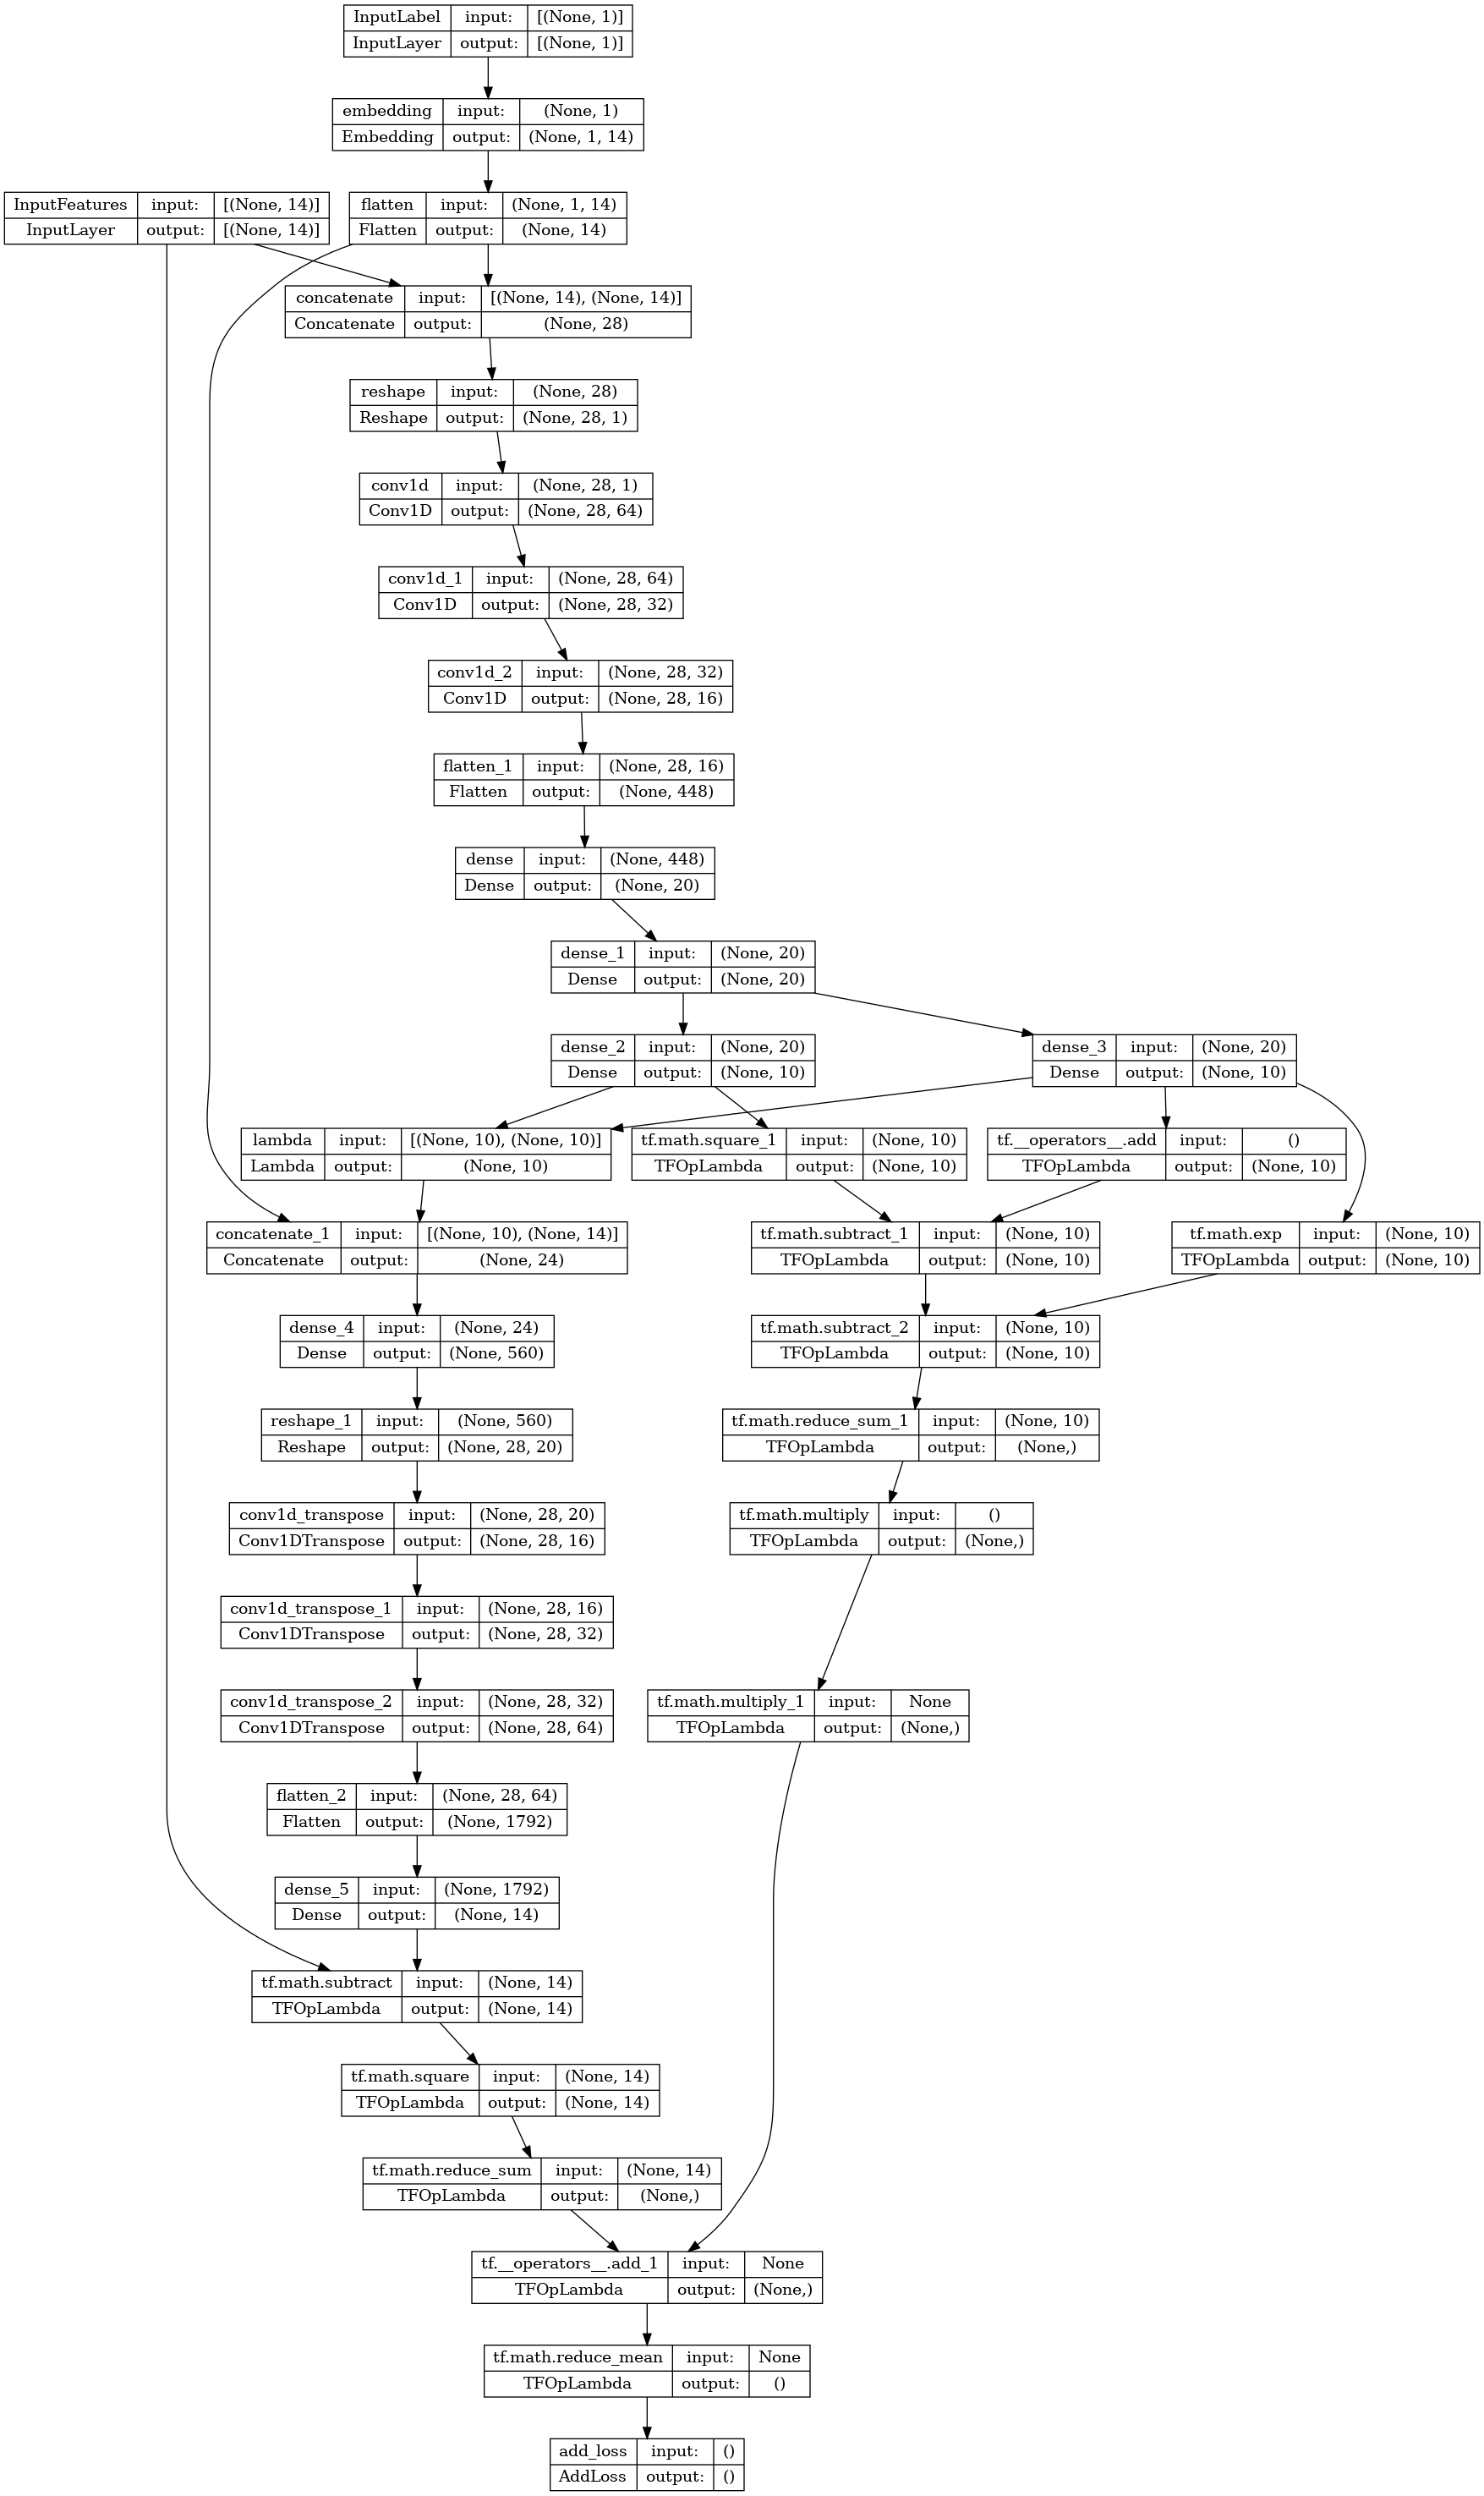

In [75]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

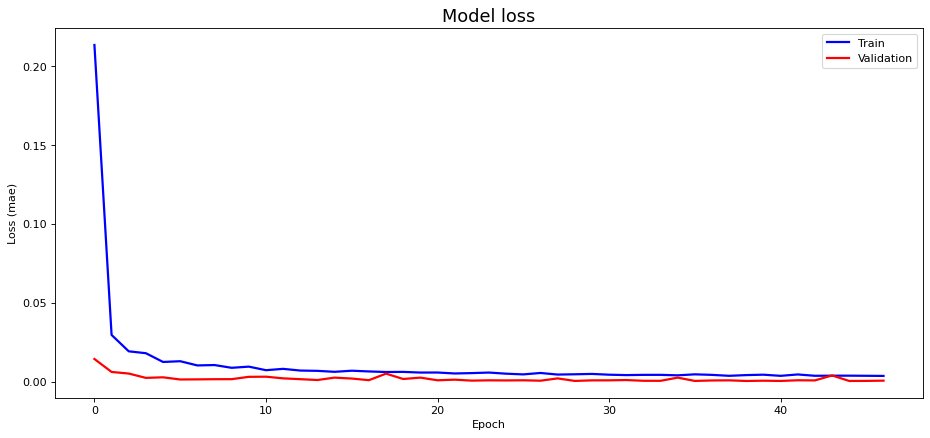

In [76]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [77]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [78]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

4642/4642 [==============================] - 9s 2ms/step


In [79]:
error_df

,reconstruction_error,true_class
0,0.136940,0
1,0.319267,0
2,0.165466,1
3,0.081856,0
4,0.112202,0
...,...,...
148512,0.259513,0
148513,0.116522,0
148514,0.117696,1
148515,0.184510,0


In [80]:
error_df[error_df['true_class']==0]

,reconstruction_error,true_class
0,0.136940,0
1,0.319267,0
3,0.081856,0
4,0.112202,0
12,0.127870,0
...,...,...
148506,0.124023,0
148508,0.129364,0
148512,0.259513,0
148513,0.116522,0


/tmp/ipykernel_2838/349485020.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


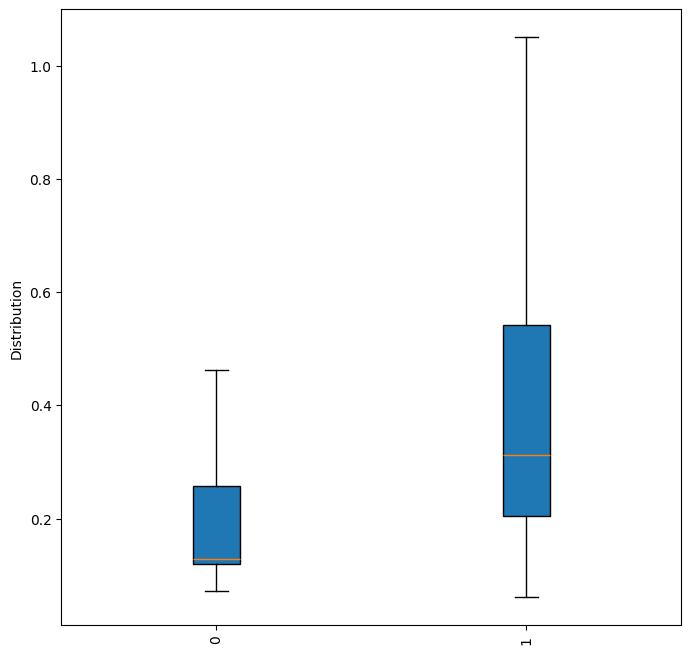

In [81]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


Best threshold: 0.14
Best F1 score: 0.7832097386913938


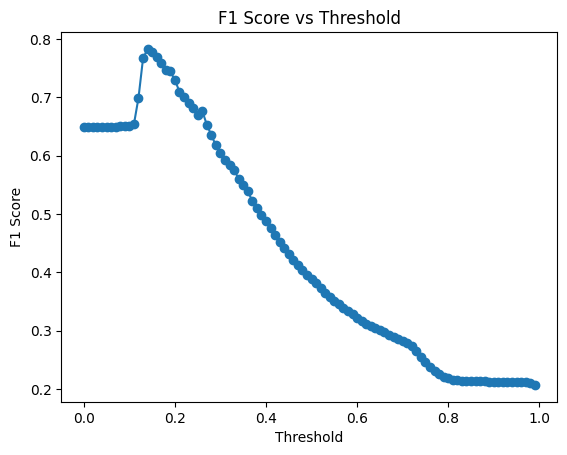

In [82]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(0, 1, 0.01)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


In [83]:
# 그래프 보고 threshold 결정 0.35
threshold = 0.14

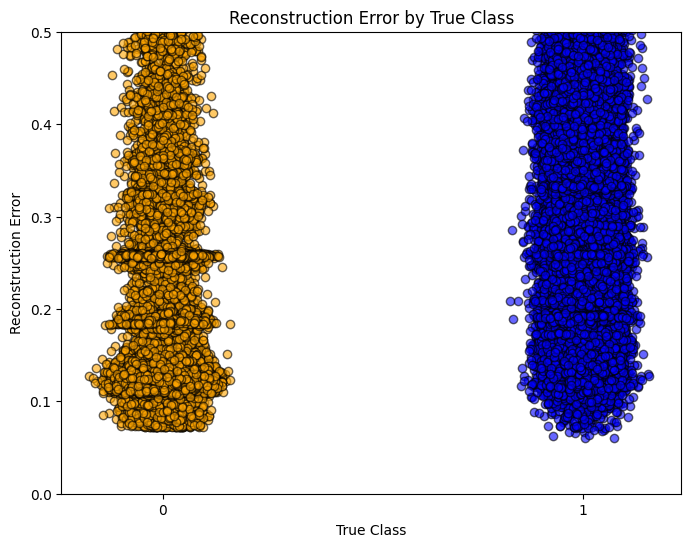

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 0.5)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


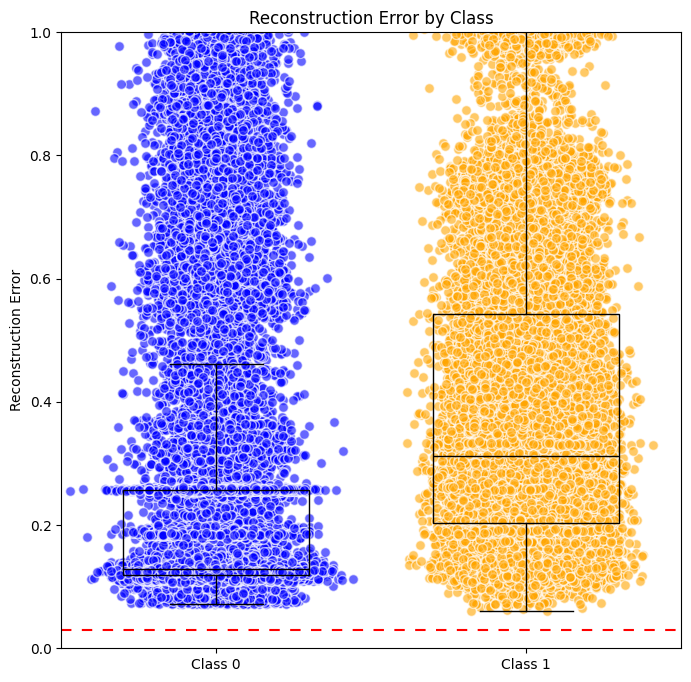

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=1)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


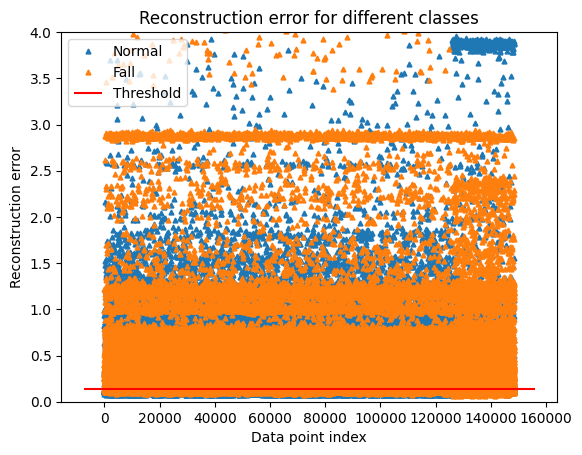

In [86]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 1200x1200 with 0 Axes>

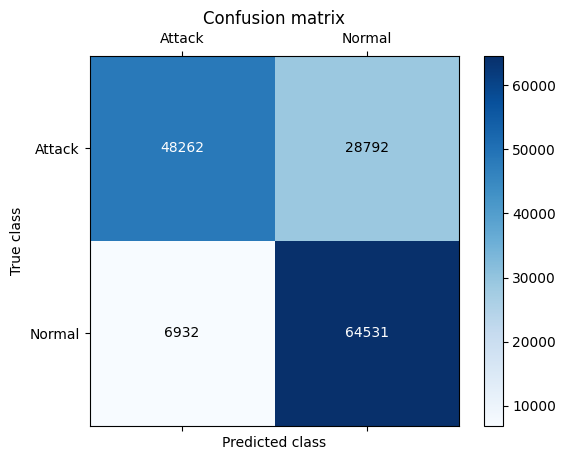

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [88]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.7594618797848057
Precision : 0.691480128157046
Recall : 0.9029987546002827
F1 : 0.7832097386913938


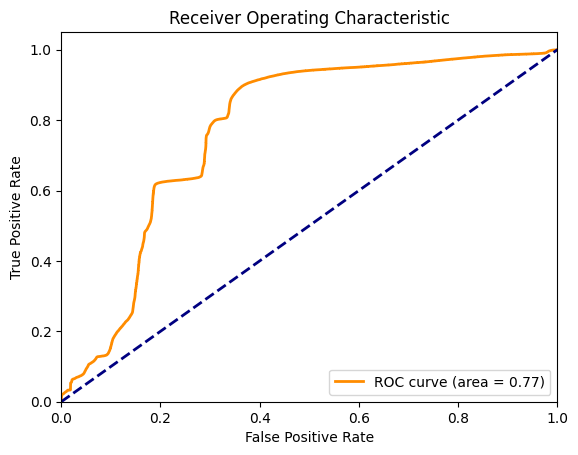

In [89]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


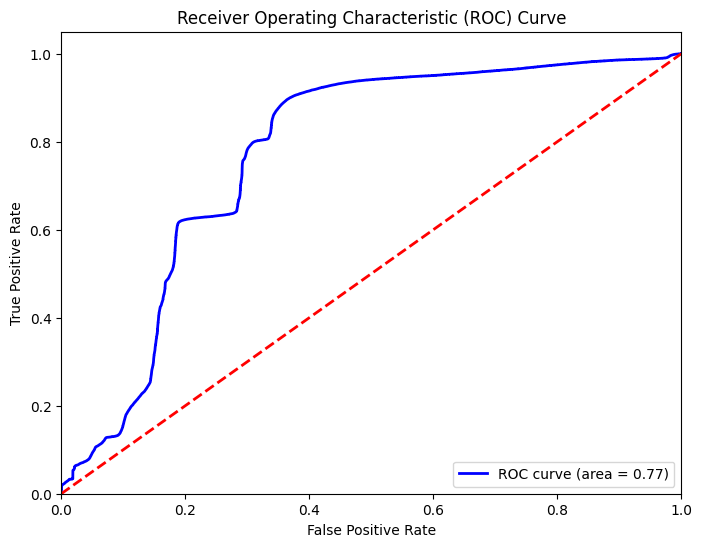

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [91]:
print(f"ROC Score : {roc_auc}")

ROC Score : 0.7727190293769669


In [92]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.7594618797848057
Precision: 0.691480128157046
Recall: 0.9029987546002827
F1 Score: 0.7832097386913938
